# Module 1.6: First Contact with the Data

> **Goal:** Run first-contact checks to confirm the data can support the 5Q Framework.

Each section maps to a 5Q question:

| Q | Name | What It Defines | First Contact Check |
|---|------|-----------------|---------------------|
| **Q1** | Decision | The Target | Is `y` clear, numeric, clean? |
| **Q2** | Metric | What "Good" Means | Issues that bias evaluation? (NAs, duplicates) |
| **Q3** | Horizon & Level | The Structure | Enough history? Right granularity? |
| **Q4** | Data & Drivers | What Model Learns | Behavioral signals (zeros, volatility) |

## 1. Setup

In [1]:
# =============================================================================
# SETUP
# =============================================================================

# --- Imports ---
import sys
import warnings
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from dtype_diet import optimize_dtypes, report_on_dataframe

# --- Path Configuration (before local imports) ---
MODULE_DIR = Path().resolve()
PROJECT_ROOT = MODULE_DIR.parent.parent
sys.path.insert(0, str(PROJECT_ROOT))

# --- Local Imports ---
import tsforge as tsf
from src import (
    load_m5,
    CacheManager,
    ArtifactManager,
    first_contact_check,
    get_notebook_name,
)

# --- Settings ---
warnings.filterwarnings("ignore")
plt.style.use("seaborn-v0_8-whitegrid")

# --- Paths ---
DATA_DIR = PROJECT_ROOT / "data"
DATA_DIR.mkdir(exist_ok=True)

# --- Managers ---
NB_NAME = get_notebook_name()  # e.g., '1_06_first_contact'
cache = CacheManager(PROJECT_ROOT / ".cache" / NB_NAME)
artifacts = ArtifactManager(PROJECT_ROOT / "artifacts")

print(f"✓ Setup complete | Root: {PROJECT_ROOT.name} | Module: {NB_NAME[:4]}")


✓ Setup complete | Root: real-world-forecasting-foundations | Module: 1.06


## 2. Load Data

`messify=True` simulates real-world data issues (string dtypes, NaN injection, duplicates, etc).

In [2]:
# M5 data downloads to ROOT_DIR/data, messified cache goes to DATA_DIR
daily_sales = load_m5(
    DATA_DIR,
    cache=cache,
    cache_key='m5_messified',
    messify=True,
    messify_config={
       'random_state': 42,
        'zeros_to_na_frac': 0.30,         # 30% of zeros → NA
        'zeros_drop_frac': 0.02,           # Drop 2% of zero rows
        'zeros_drop_gaps_frac': 0.10,      # Drop 10% of zeros (gaps)
        'duplicates_add_n': 150,           # Add 150 duplicates
        'na_drop_frac': None,              # Don't drop NAs
        'dtypes_corrupt': True,            # Corrupt dtypes
    },
    include_hierarchy=True,
)

⚠ Cache 'm5_messified' not found
🔄 Cache miss for 'm5_messified' - creating fresh...
LOADING M5 DATA
✓ M5 cache detected. Loading from local files...
✓ Loaded in 1.1s
  Shape: 47,649,940 rows × 3 columns
  Memory: 638.4 MB

🔧 Applying messification...
Step 1/6: Converting zeros to NAs...
  ✓ Converted 8,498,628 zeros to NAs
Step 2/6: Adding duplicate rows...
  ✓ Added 150 duplicate rows
Step 3/6: Dropping zero-demand rows (sparse reporting)...
  ✓ Dropped 396,603 zero-demand rows
Step 4/6: Dropping NA rows... [SKIPPED]
Step 5/6: Creating internal gaps (dropping middle zeros)...
  ✓ Dropped 1,942,198 zeros from middle of series
Step 6/6: Corrupting data types...
  ✓ Converted ds to string
  ✓ Converted y to string

DATA MESSIFICATION SUMMARY

Original shape: 47,649,940 rows × 3 columns
Messified shape: 45,311,289 rows × 3 columns

Changes applied (6):
  1. Converted 8,498,628 zeros to NAs (30% of zeros)
  2. Added 150 duplicate rows
  3. Dropped 396,603 zero-demand rows (2% of zeros)
  

---

<div style="text-align: center;">

## 3. `Q1: Decision` — Defines the Target

<div style="background: linear-gradient(135deg, #11998e 0%, #38ef7d 100%); color: white; padding: 12px 20px; border-radius: 8px; margin: 10px auto; max-width: 600px;">
<strong>Is the target clear, numeric, and clean?</strong><br>
</div>

</div>


### 3.1 Identify the Target

In [3]:
# What columns do we have?
daily_sales.columns

Index(['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'unique_id',
       'ds', 'y'],
      dtype='object')

### 3.2 Check Data Types

In [4]:
daily_sales[['ds', 'y']].dtypes

ds    object
y     object
dtype: object

### 3.3 Fix Data Type Issues

Messification corrupts dtypes. `errors='coerce'` converts unparseable values to proper NaN.

In [5]:
daily_sales['ds'] = pd.to_datetime(daily_sales['ds'])
daily_sales['y'] = pd.to_numeric(daily_sales['y'], errors='coerce')

In [6]:
daily_sales[['ds', 'y']].dtypes

ds    datetime64[ns]
y            float64
dtype: object

---

<div style="text-align: center;">

## 4. `Q2: Metric` — Defines What "Good" Means

<div style="background: linear-gradient(135deg, #667eea 0%, #764ba2 100%); color: white; padding: 12px 20px; border-radius: 8px; margin: 10px auto; max-width: 600px;">
<strong>Are there issues that would bias our evaluation?</strong><br>
<em>Missingness, duplicates, and orphan data corrupt metrics.</em>
</div>

</div>


### 4.1 Check for Missing Values

In [7]:
daily_sales.isna().sum()

item_id            0
dept_id            0
cat_id             0
store_id           0
state_id           0
unique_id          0
ds                 0
y            8498653
dtype: int64

### 4.2 Handle Critical NAs

Drop rows with null dates (can't aggregate without a date). Target NAs handled in Module 1.10.

In [8]:
daily_sales = daily_sales.dropna(subset=['ds'])

### 4.3 Check for Null IDs

Rows with null ID columns are orphan data — they can't be aggregated properly.

In [9]:
id_cols = [c for c in daily_sales.columns if c not in ['ds', 'y']]
daily_sales[id_cols].isna().sum()

item_id      0
dept_id      0
cat_id       0
store_id     0
state_id     0
unique_id    0
dtype: int64

### 4.4 Check for Duplicates

Duplicates inflate aggregates and bias metrics. Remove before aggregating.

In [10]:
non_target_cols = [c for c in daily_sales.columns if c != 'y']
n_dups = daily_sales.duplicated(subset=non_target_cols)

In [11]:
n_dups.value_counts()

False    45311160
True          129
Name: count, dtype: int64

In [12]:
daily_sales = daily_sales.drop_duplicates(subset=non_target_cols)

---

<div style="text-align: center;">

## Q3: Horizon & Level — Defines the Structure

<div style="background: linear-gradient(135deg, #4facfe 0%, #00f2fe 100%); color: white; padding: 12px 20px; border-radius: 8px; margin: 10px auto; max-width: 600px;">
<strong>Do we have enough history at the right granularity?</strong><br>
</div>

</div>


### 5.1 Daily Data Summary

In [13]:
# inspect daily_sales before aggregating 
daily_sales.head(10)

,item_id,dept_id,cat_id,store_id,state_id,unique_id,ds,y
0,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,FOODS_1_001_CA_1,2011-01-29,3.0
1,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,FOODS_1_001_CA_1,2011-01-30,0.0
2,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,FOODS_1_001_CA_1,2011-01-31,0.0
3,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,FOODS_1_001_CA_1,2011-02-01,1.0
4,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,FOODS_1_001_CA_1,2011-02-02,4.0
5,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,FOODS_1_001_CA_1,2011-02-03,2.0
6,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,FOODS_1_001_CA_1,2011-02-04,NaN
7,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,FOODS_1_001_CA_1,2011-02-05,2.0
8,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,FOODS_1_001_CA_1,2011-02-06,0.0
9,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,FOODS_1_001_CA_1,2011-02-07,0.0


### 5.2 Check Date Range

Rule of thumb: need 2-3x forecast horizon. For 12-week forecast, want ~36+ weeks.

In [14]:
# min date
daily_sales['ds'].min()

Timestamp('2011-01-29 00:00:00')

In [15]:
# max date
daily_sales['ds'].max()

Timestamp('2016-06-19 00:00:00')

In [16]:
# number of weeks
((daily_sales['ds'].max() - daily_sales['ds'].min()).days // 7) + 1

282

### 5.3 Check for Weird Dates

Look for dates before 1900, future dates, or outlier dates far from the main range.

In [17]:
unique_dates = (
    daily_sales['ds']
    .dropna()
    .drop_duplicates()
    .sort_values()
)

unique_dates.head(5), unique_dates.tail(5)

(0   2011-01-29
 1   2011-01-30
 2   2011-01-31
 3   2011-02-01
 4   2011-02-02
 Name: ds, dtype: datetime64[ns],
 1881   2016-06-15
 1882   2016-06-16
 1883   2016-06-17
 1884   2016-06-18
 1885   2016-06-19
 Name: ds, dtype: datetime64[ns])

### 5.4 Aggregate to Weekly

Weekly aligns with business planning (replenishment, labor, promos) and reduces daily noise.

In [18]:
# Group columns (everything except ds and y)
group_cols = [c for c in daily_sales.columns if c not in ['ds', 'y']]

In [19]:
# Create week column (W-SAT = weeks starting Sunday, ending Saturday)
daily_sales['week'] = daily_sales['ds'].dt.to_period('W-SAT').dt.start_time

In [20]:
# Aggregate: group by all id columns + week, sum the target
weekly_sales = (
    daily_sales.groupby(group_cols + ['week'], as_index=False, observed=True)
    ['y']
    .sum()
    .rename(columns={'week': 'ds'})
)

### 5.4 Daily vs Weekly Comparison

Compare the same series at daily vs weekly granularity.

In [21]:
# create a sample series by pulling the first unique series
first_series = daily_sales[group_cols].drop_duplicates().iloc[0]

# Filter data for this series
daily_mask = (daily_sales[group_cols] == first_series).all(axis=1)
weekly_mask = (weekly_sales[group_cols] == first_series).all(axis=1)


In [22]:
sample_daily = daily_sales[daily_mask].sort_values('ds')
sample_weekly = weekly_sales[weekly_mask].sort_values('ds')

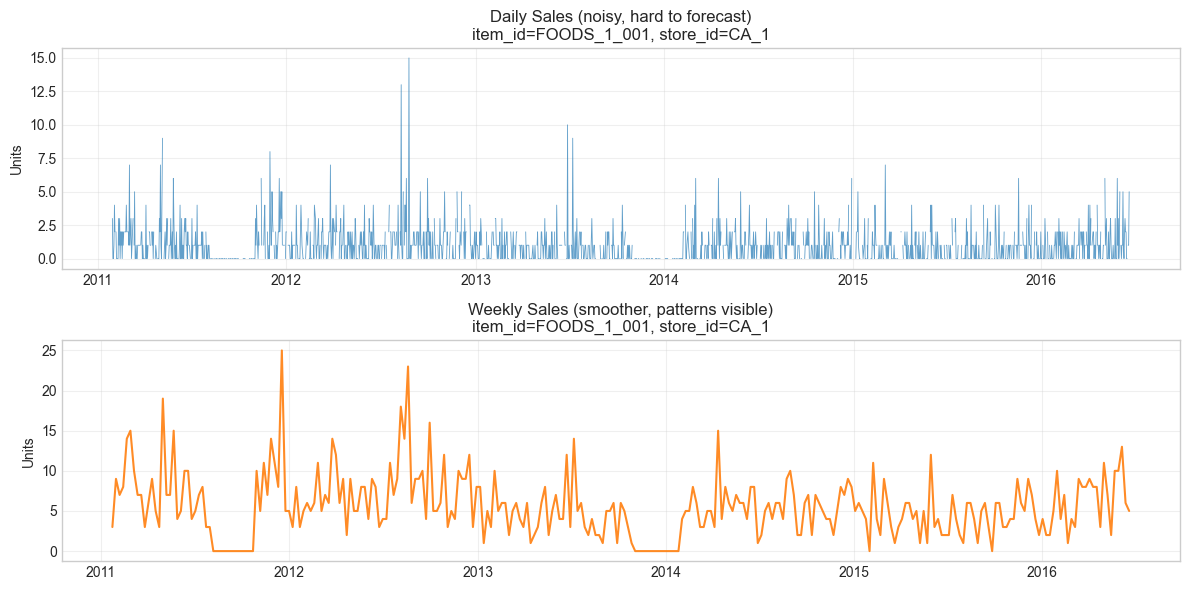

In [23]:
# Create label from series identifiers
label = f"item_id={first_series['item_id']}, store_id={first_series['store_id']}"

# Plot daily vs weekly
fig, axes = plt.subplots(2, 1, figsize=(12, 6))

axes[0].plot(sample_daily['ds'], sample_daily['y'], alpha=0.7, linewidth=0.6)
axes[0].set_title(f'Daily Sales (noisy, hard to forecast)\n{label}')
axes[0].set_ylabel('Units')
axes[0].grid(True, alpha=0.3)

axes[1].plot(sample_weekly['ds'], sample_weekly['y'], alpha=0.9, linewidth=1.5, color='tab:orange')
axes[1].set_title(f'Weekly Sales (smoother, patterns visible)\n{label}')
axes[1].set_ylabel('Units')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

<div style="text-align: center;">

## 5. `Q4: Data` — Defines What the Model Learns

<div style="background: linear-gradient(135deg, #f093fb 0%, #f5576c 100%); color: white; padding: 12px 20px; border-radius: 8px; margin: 10px auto; max-width: 600px;">
<strong>What behavioral signals shape model selection?</strong><br>
<em>Intermittency, volatility, and data quality affect what the model can learn.</em>
</div>

</div>


### 6.1 Intermittency (Zeros)

High % zeros affects metric choice (MAPE undefined at 0) and model selection.

In [24]:
n_zeros = (weekly_sales['y'] == 0).sum()
n_na = weekly_sales['y'].isna().sum()

In [25]:
# percent of data with 0 sales
((n_zeros+n_na) / len(weekly_sales) * 100)

24.02633925168771

### 6.2 Data Summary

In [26]:
# before aggregating
daily_sales.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Index: 45311160 entries, 0 to 45311288
Data columns (total 9 columns):
 #   Column     Dtype         
---  ------     -----         
 0   item_id    category      
 1   dept_id    category      
 2   cat_id     category      
 3   store_id   category      
 4   state_id   category      
 5   unique_id  category      
 6   ds         datetime64[ns]
 7   y          float64       
 8   week       datetime64[ns]
dtypes: category(6), datetime64[ns](2), float64(1)
memory usage: 1.7 GB


In [27]:
# after aggregating
weekly_sales.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6848638 entries, 0 to 6848637
Data columns (total 8 columns):
 #   Column     Dtype         
---  ------     -----         
 0   item_id    category      
 1   dept_id    category      
 2   cat_id     category      
 3   store_id   category      
 4   state_id   category      
 5   unique_id  category      
 6   ds         datetime64[ns]
 7   y          float64       
dtypes: category(6), datetime64[ns](1), float64(1)
memory usage: 160.2 MB


---

## 7. First Contact Summary

Automated check across all 5Q dimensions:

In [28]:
# Module 1.06 - First Contact
report = first_contact_check(weekly_sales, dataset_name='Weekly M5 Sales')


In [29]:
report.table()

Category,Check,Status,Value,Notes
Schema,Column: ds,✓,Present,Required
Schema,Column: y,✓,Present,Required
Schema,Type: ds,✓,datetime64[ns],
Schema,Type: y,✓,float64,
Completeness,NAs: ds,✓,0,
Completeness,NAs: y,✓,0 (0.0%),
Completeness,NAs: ID columns,✓,0,
Validity,Dates ≥ 1900,✓,0 invalid,
Validity,No future dates,✓,0 future,
Validity,y ≥ 0,ℹ,0 negative,Review if unexpected


## 8. Save Output

Save cleaned weekly data. NAs preserved for gap-filling in Module 1.10.

In [30]:
# =============================================================================
# OPTIMIZE & CACHE OUTPUT
# =============================================================================

# Optimize memory
dtype_report = report_on_dataframe(weekly_sales, unit="MB")
dtype_report.loc["y", "Proposed dtype"] = "float64"
weekly_sales_opt = optimize_dtypes(weekly_sales, dtype_report)

mem_before = weekly_sales.memory_usage(deep=True).sum() / 1e6
mem_after = weekly_sales_opt.memory_usage(deep=True).sum() / 1e6
print(f"Memory: {mem_before:.1f} MB → {mem_after:.1f} MB ({mem_after/mem_before:.0%})")

Memory: 168.0 MB → 168.0 MB (100%)


In [32]:
# Cache for downstream modules
artifacts.save(
    df=weekly_sales_opt,
    report=report
)

✓ Saved report to 1.06.json
✓ Saved '1.06' → 01_foundations/
   Data:   output/1.06.parquet (8.09 MB, 6,848,638 rows)
   Report: reports/1.06.json


PosixPath('/Users/lindsaytruong/forecast-academy/real-world-forecasting-foundations/artifacts/01_foundations/output/1.06.parquet')

## 9. Next Steps

| Module | Focus |
|--------|-------|
| **1.7** | Understand M5 structure (hierarchy, calendar, prices) |
| **1.8** | Diagnostics (seasonality, volatility, trend) |
| **1.9** | Portfolio analysis with GenAI |
| **1.10** | Data preparation (fill gaps, calendar merge, imputation) |
| **1.11** | Plotting & visual diagnostics |